In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pwd

/home/rw2967


In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##########################################
# 数据读取与处理
##########################################
df = pd.read_csv("/home/rw2967/AMD.csv", parse_dates=["DateTime"], index_col="DateTime")
df = df.sort_index()
df = df.ffill()  # 前向填充

df = df[(df.index >= '2000-01-01') & (df.index <= '2010-01-01')]

df.columns = df.columns.str.lower()
feature_cols = ["open", "high", "low", "close", "volume"]

agg_dict = {
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}

df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')

df_15min = df_15min.rename(columns=lambda c: c.lower()+"_15")
df_30min = df_30min.rename(columns=lambda c: c.lower()+"_30")
df_60min = df_60min.rename(columns=lambda c: c.lower()+"_60")

df_all = df_15min.join(df_30min, how="inner").join(df_60min, how="inner")
print("df_all columns:", df_all.columns)

short_cols = [col+"_15" for col in feature_cols]
mid_cols = [col+"_30" for col in feature_cols]
long_cols = [col+"_60" for col in feature_cols]

all_feature_cols = short_cols + mid_cols + long_cols


/tmp/ipykernel_5615/3809317925.py:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
/tmp/ipykernel_5615/3809317925.py:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
/tmp/ipykernel_5615/3809317925.py:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')


df_all columns: Index(['open_15', 'high_15', 'low_15', 'close_15', 'volume_15', 'open_30',
       'high_30', 'low_30', 'close_30', 'volume_30', 'open_60', 'high_60',
       'low_60', 'close_60', 'volume_60'],
      dtype='object')


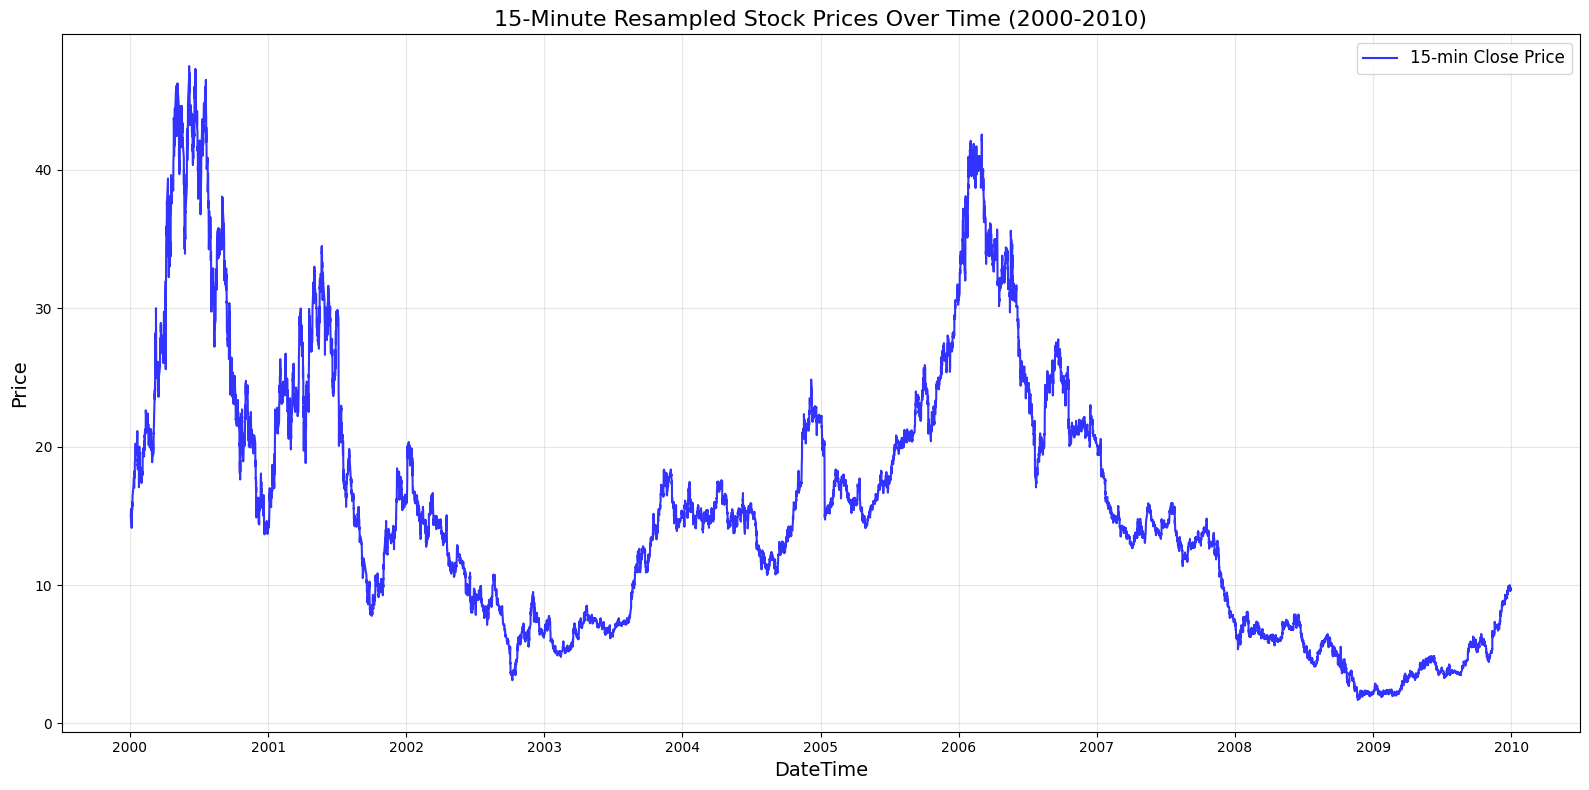

In [4]:
import matplotlib.pyplot as plt

# Plot the 'close_15' price over time
plt.figure(figsize=(16, 8))
plt.plot(df_all.index, df_all['close_15'], label='15-min Close Price', color='blue', alpha=0.8)

# Adding labels and title
plt.title("15-Minute Resampled Stock Prices Over Time (2000-2010)", fontsize=16)
plt.xlabel("DateTime", fontsize=14)
plt.ylabel("Price", fontsize=14)

# Adding grid and legend
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

# Show plot
plt.tight_layout()
plt.show()


/ext3/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_5615/3276757481.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(target_seq, dtype=torch.float32),


Epoch [1/10], Average Loss: 0.0011
Epoch [2/10], Average Loss: 0.0003
Epoch [3/10], Average Loss: 0.0002
Epoch [4/10], Average Loss: 0.0001
Epoch [5/10], Average Loss: 0.0001
Epoch [6/10], Average Loss: 0.0001
Epoch [7/10], Average Loss: 0.0001
Epoch [8/10], Average Loss: 0.0001
Epoch [9/10], Average Loss: 0.0001
Epoch [10/10], Average Loss: 0.0001
Evaluation Results on Denormalized Scale (Test Set):
MSE: 0.0252
RMSE: 0.1587
MAE: 0.1280
R²: 0.9916


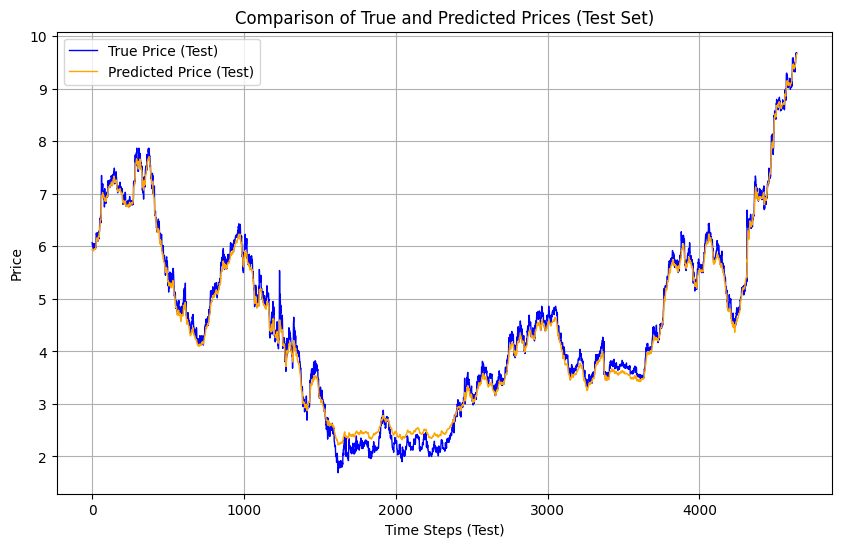

In [5]:

# 使用MinMaxScaler进行归一化
scaler = MinMaxScaler()
df_all[all_feature_cols] = scaler.fit_transform(df_all[all_feature_cols])

# 数据划分为训练集和测试集（如80%训练，20%测试）
N = len(df_all)
train_ratio = 0.8
train_size = int(N * train_ratio)

train_df = df_all.iloc[:train_size]
test_df = df_all.iloc[train_size:]

train_short_data = train_df[short_cols].values
train_mid_data = train_df[mid_cols].values
train_long_data = train_df[long_cols].values
train_close_15_series = train_df["close_15"].values

test_short_data = test_df[short_cols].values
test_mid_data = test_df[mid_cols].values
test_long_data = test_df[long_cols].values
test_close_15_series = test_df["close_15"].values

seq_len_short = 16
seq_len_mid = 32
seq_len_long = 64

##########################################
# 定义Dataset
##########################################
class MultiScaleStockDataset(Dataset):
    def __init__(self, short_data, mid_data, long_data, close_label,
                 seq_len_short, seq_len_mid, seq_len_long):
        super().__init__()
        self.short_data = short_data
        self.mid_data = mid_data
        self.long_data = long_data
        self.close_label = close_label
        self.seq_len_short = seq_len_short
        self.seq_len_mid = seq_len_mid
        self.seq_len_long = seq_len_long

        self.length = len(short_data) - max(seq_len_short, seq_len_mid, seq_len_long) - 1
        if self.length < 1:
            raise ValueError("Not enough data to form a single sample.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        start = idx
        end_short = start + self.seq_len_short
        end_mid = start + self.seq_len_mid
        end_long = start + self.seq_len_long

        target_idx = end_short
        short_seq = self.short_data[start:end_short]
        mid_seq = self.mid_data[start:end_mid]
        long_seq = self.long_data[start:end_long]

        label = self.close_label[target_idx]
        # target_seq = torch.zeros(1, short_seq.shape[1])  # decoder输入为0
        # 将 target_seq 设置为短期序列的最后一个时间步的特征，而不是全零
        target_seq = torch.tensor(short_seq[-1], dtype=torch.float32).unsqueeze(0)  # shape: (1, num_features)


        return (torch.tensor(short_seq, dtype=torch.float32),
                torch.tensor(mid_seq, dtype=torch.float32),
                torch.tensor(long_seq, dtype=torch.float32),
                torch.tensor(target_seq, dtype=torch.float32),
                torch.tensor([label], dtype=torch.float32))


train_dataset = MultiScaleStockDataset(train_short_data, train_mid_data, train_long_data, train_close_15_series,
                                       seq_len_short, seq_len_mid, seq_len_long)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MultiScaleStockDataset(test_short_data, test_mid_data, test_long_data, test_close_15_series,
                                      seq_len_short, seq_len_mid, seq_len_long)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

##########################################
# 模型定义
##########################################
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

class MultiScaleTransformer(nn.Module):
    def __init__(self,
                 feature_dim,
                 d_model,
                 nhead,
                 num_encoder_layers,
                 num_decoder_layers,
                 output_dim,
                 mlp_hidden_dim=128):
        super(MultiScaleTransformer, self).__init__()

        self.embedding = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)

        self.short_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.short_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.mid_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.mid_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.long_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.long_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.conv_fusion = nn.Conv1d(in_channels=3*d_model, out_channels=d_model, kernel_size=1)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, output_dim)
        )

    def forward(self, short_input, mid_input, long_input, target_seq):
        short_embed = self.embedding(short_input)
        mid_embed = self.embedding(mid_input)
        long_embed = self.embedding(long_input)

        tgt_embed = self.embedding(target_seq)
        tgt_embed = self.pos_encoder(tgt_embed).permute(1,0,2)

        short_embed = self.pos_encoder(short_embed).permute(1,0,2)
        mid_embed = self.pos_encoder(mid_embed).permute(1,0,2)
        long_embed = self.pos_encoder(long_embed).permute(1,0,2)

        short_enc = self.short_encoder(short_embed)
        mid_enc = self.mid_encoder(mid_embed)
        long_enc = self.long_encoder(long_embed)

        short_dec = self.short_decoder(tgt=tgt_embed, memory=short_enc)
        mid_dec = self.mid_decoder(tgt=tgt_embed, memory=mid_enc)
        long_dec = self.long_decoder(tgt=tgt_embed, memory=long_enc)

        short_feat = short_dec[0]
        mid_feat = mid_dec[0]
        long_feat = long_dec[0]

        fusion_feat = torch.cat([short_feat, mid_feat, long_feat], dim=-1)
        fusion_feat = fusion_feat.unsqueeze(-1)
        fusion_feat = self.conv_fusion(fusion_feat)
        fusion_feat = fusion_feat.squeeze(-1)

        output = self.mlp(fusion_feat)
        return output

##########################################
# 训练
##########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_dim = len(feature_cols) # now 4
d_model = 64
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
output_dim = 1
lr = 1e-4
epochs = 10

model = MultiScaleTransformer(feature_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    batch_count = 0
    for i, (short_seq, mid_seq, long_seq, tgt_seq, label) in enumerate(train_dataloader, start=1):
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(short_seq, mid_seq, long_seq, tgt_seq)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * short_seq.size(0)
        batch_count += short_seq.size(0)

    avg_loss = epoch_loss / batch_count
    print(f"Epoch [{epoch}/{epochs}], Average Loss: {avg_loss:.4f}")

##########################################
# 在测试集上进行预测和评估
##########################################
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for (short_seq, mid_seq, long_seq, tgt_seq, label) in test_dataloader:
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        pred = model(short_seq, mid_seq, long_seq, tgt_seq)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(label.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

num_samples = all_preds.shape[0]
num_features = len(all_feature_cols)
close_15_index = all_feature_cols.index("close_15")

preds_extended = np.zeros((num_samples, num_features))
labels_extended = np.zeros((num_samples, num_features))

preds_extended[:, close_15_index] = all_preds[:, 0]
labels_extended[:, close_15_index] = all_labels[:, 0]

inv_preds = scaler.inverse_transform(preds_extended)[:, close_15_index]
inv_labels = scaler.inverse_transform(labels_extended)[:, close_15_index]

# 计算指标
mse = mean_squared_error(inv_labels, inv_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_labels, inv_preds)
r2 = r2_score(inv_labels, inv_preds)

print("Evaluation Results on Denormalized Scale (Test Set):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# 画出测试集部分的对比图
plt.figure(figsize=(10,6))
plt.plot(inv_labels, label="True Price (Test)", color='blue', linewidth=1.0)
plt.plot(inv_preds, label="Predicted Price (Test)", color='orange', linewidth=1.0)
plt.title("Comparison of True and Predicted Prices (Test Set)")
plt.xlabel("Time Steps (Test)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
# 可根据需要调整显示范围，例如：
# plt.ylim(20000, 22000)
plt.show()